In [ ]:
!rm -rf *.png out.zip

In [ ]:
opt_name = "vit"

#Fold vs Prune and Ablations

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib import colormaps
from pathlib import Path
import seaborn as sns


# Load text content
with open(f"fold", "r") as f:
    fold_text = f.read()
with open(f"mag-l1", "r") as f:
    mag1_text = f.read()
with open(f"mag-l2", "r") as f:
    mag2_text = f.read()

FILTER_THRESHOLD = 80.0

594 594 594


/tmp/ipython-input-3907625196.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


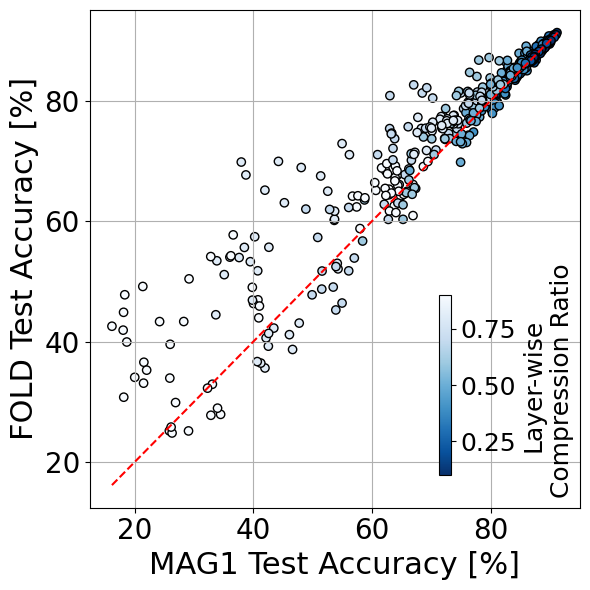

/tmp/ipython-input-3907625196.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


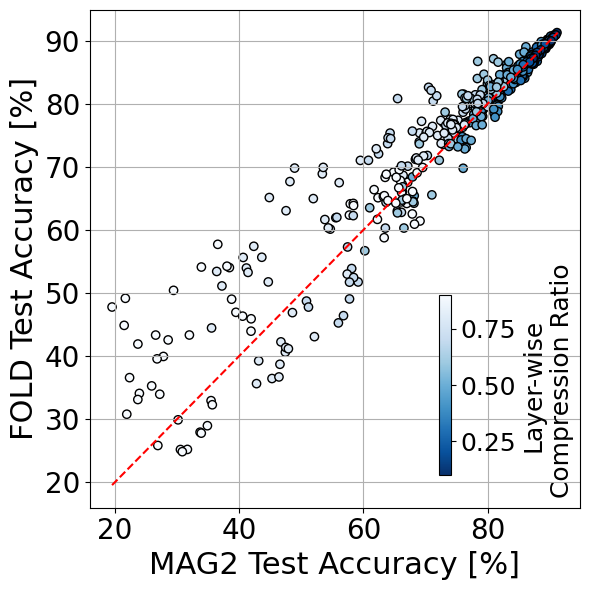

In [ ]:
import re
import pandas as pd

def extract_before_after_with_id(text):
    # Match each [MODEL] block
    pattern = re.compile(r"\[MODEL\]\s+(\d+)/\d+.*?([^\s]+\.pth)(.*?)(?=\[MODEL\]|\Z)", re.DOTALL)
    entries = []
    for match in pattern.finditer(text):
        model_id = match.group(1)
        model_name = match.group(2)
        block = match.group(3)

        # Baseline (RATIO=0.0, EVENT=BASE)
        base_match = re.search(r"RATIO=0\.0\s+EVENT=BASE[^\n]*acc=([0-9.]+)", block)
        if not base_match:
            continue
        acc_before = float(base_match.group(1))

        if acc_before < FILTER_THRESHOLD:
          continue

        # REPAIR events for other ratios
        # Match lines like "RATIO=0.1 EVENT=PRUNE acc=93.33"
        repair_pattern = r"RATIO=([0-9.]+)\s+EVENT=PRUNE[^\n]*acc=([0-9.]+)"
        for ratio_str, acc_after_str in re.findall(repair_pattern, block):
            entries.append((
                model_id,
                model_name,
                float(ratio_str),
                acc_before,
                float(acc_after_str)
            ))

    return pd.DataFrame(entries, columns=["model_id", "model", "ratio", "acc_before", "acc_after"])


def plot_compration_ratio_scatter(x_df, y_df, x_name, y_name):
    # Rename
    x_df = x_df.rename(columns={"acc_after": "acc_x"})
    y_df = y_df.rename(columns={"acc_after": "acc_y"})
    # Reduce
    y_df = y_df[["model_id", "model", "ratio", "acc_y"]]
    x_df = x_df[["model_id", "model", "ratio", "acc_x"]]
    # Merge
    merged_df = pd.merge(y_df, x_df, on=["model_id", "model", "ratio"])

    norm = plt.Normalize(merged_df["ratio"].min(), merged_df["ratio"].max())
    cmap = cm.Blues_r

    # Plot with doubled font sizes
    fig, ax = plt.subplots(figsize=(6, 6))

    scatter = ax.scatter(
        merged_df["acc_x"], merged_df["acc_y"],
        c=merged_df["ratio"], cmap=cmap, norm=norm,
        marker='o', edgecolor='black'
    )

    min_val = merged_df[["acc_x", "acc_y"]].min().min()
    max_val = merged_df[["acc_x", "acc_y"]].max().max()
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', label="y = x")

    # Axis labels
    ax.set_xlabel(f"{x_name} Test Accuracy [%]", fontsize=22)
    ax.set_ylabel(f"{y_name} Test Accuracy [%]", fontsize=22)

    # Tick labels
    ax.tick_params(axis='both', labelsize=20)

    # Colorbar
    cbar_ax = fig.add_axes([0.74, 0.20, 0.02, 0.3])
    smap = cm.ScalarMappable(norm=norm, cmap=cmap)
    cbar = fig.colorbar(smap, cax=cbar_ax, ax=ax, fraction=0.035, pad=0.02)
    cbar.set_label("Layer-wise\n Compression Ratio", fontsize=18)
    cbar.ax.tick_params(labelsize=18)

    # Grid and layout
    ax.grid(True)
    fig.tight_layout()
    plt.show()
    fig.savefig(f"{opt_name}__compression_ratio_scatter__{x_name}_vs_{y_name}.png", dpi=100)


# Extract
fold_df = extract_before_after_with_id(fold_text)
mag1_df = extract_before_after_with_id(mag1_text)
mag2_df = extract_before_after_with_id(mag2_text)

# Print
print(len(fold_df), len(mag1_df), len(mag2_df))

plot_compration_ratio_scatter(mag1_df, fold_df, "MAG1", "FOLD")
plot_compration_ratio_scatter(mag2_df, fold_df, "MAG2", "FOLD")


594 594 594


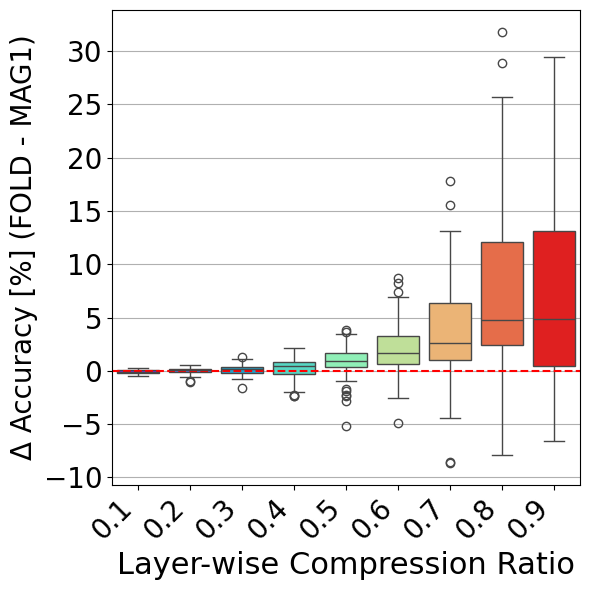

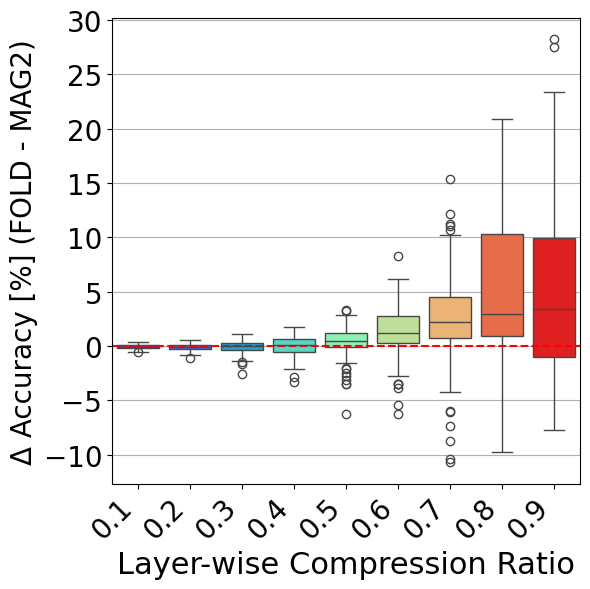

In [ ]:
def extract_with_relative_accuracy(text):
    # Match each model block
    pattern = re.compile(r"\[MODEL\] (\d+)/\d+\s+(.*?)\.pth(.*?)(?=\[MODEL\]|\Z)", re.DOTALL)
    entries = []

    for match in pattern.finditer(text):
        model_name = match.group(2).strip()
        block = match.group(3)

        # Extract BASE (before pruning) and REPAIR (after repair)
        before = re.findall(r"RATIO=([0-9.]+)\s+EVENT=BASE params=(\d+)\s+acc=([0-9.]+)", block)

        if before:
            base_ratio, base_params, base_acc = before[0]
            base_params = int(base_params)
            base_acc = float(base_acc)

            if base_acc < FILTER_THRESHOLD:
                continue

            # Match each PRUNE ratio and corresponding REPAIR accuracy
            prunes = re.findall(r"RATIO=([0-9.]+)\s+EVENT=PRUNE params=(\d+)\s+acc=([0-9.]+)", block)
            repairs = re.findall(r"RATIO=([0-9.]+)\s+EVENT=REPAIR acc=([0-9.]+)", block)

            for (r_p, p_p, acc_r), (r_r, _) in zip(prunes, repairs):
                if abs(float(r_p) - float(r_r)) < 1e-4:
                    sparsity = round(1.0 - int(p_p) / base_params, 2)
                    entries.append((model_name, sparsity, float(r_r), base_acc, float(acc_r)))

    return pd.DataFrame(entries, columns=["model", "sparsity", "ratio", "acc_before", "acc_after"])


def plot_compration_ratio_hist(x_df, y_df, x_name, y_name):
    # Rename
    x_df = x_df.rename(columns={"acc_after": "acc_x"})
    y_df = y_df.rename(columns={"acc_after": "acc_y"})
    # Merge
    merged_df = pd.merge(y_df[["model", "ratio", "acc_y"]], x_df[["model", "ratio", "acc_x"]], on=["model", "ratio"])

    # Compute relative difference
    merged_df["diff"] = merged_df["acc_y"] - merged_df["acc_x"]
    boxplot_df = merged_df[["ratio", "diff"]].copy()

    # Get sorted unique sparsities
    unique_sparsities = sorted(boxplot_df["ratio"].unique())
    cmap = colormaps["Blues_r"]
    palette = [cmap(0.3 + 0.6 * i / max(len(unique_sparsities) - 1, 1)) for i in range(len(unique_sparsities))]
    palette_dict = dict(zip(unique_sparsities, palette))

    # Plotting with increased font sizes
    fig = plt.figure(figsize=(6, 6))
    sns.boxplot(
        data=boxplot_df,
        x="ratio",
        y="diff",
        hue="ratio",
        palette="rainbow",
        dodge=False,
        legend=False
    )

    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Layer-wise Compression Ratio", fontsize=22)
    plt.ylabel(f"Δ Accuracy [%] ({y_name} - {x_name})", fontsize=20)

    plt.xticks(rotation=45, ha="right", fontsize=20)
    plt.yticks(fontsize=20)

    plt.grid(True, axis='y')
    # plt.ylim(-30, 40)
    plt.tight_layout()
    plt.show()
    fig.savefig(f"{opt_name}__compression_ratio_hist__{x_name}_vs_{y_name}.png", dpi=100)


# Extract
fold_df = extract_with_relative_accuracy(fold_text)
mag1_df = extract_with_relative_accuracy(mag1_text)
mag2_df = extract_with_relative_accuracy(mag2_text)

# Print
print(len(fold_df), len(mag1_df), len(mag2_df))

plot_compration_ratio_hist(mag1_df.copy(), fold_df.copy(), "MAG1", "FOLD")
plot_compration_ratio_hist(mag2_df, fold_df, "MAG2", "FOLD")


594 594 594


/tmp/ipython-input-3287580876.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


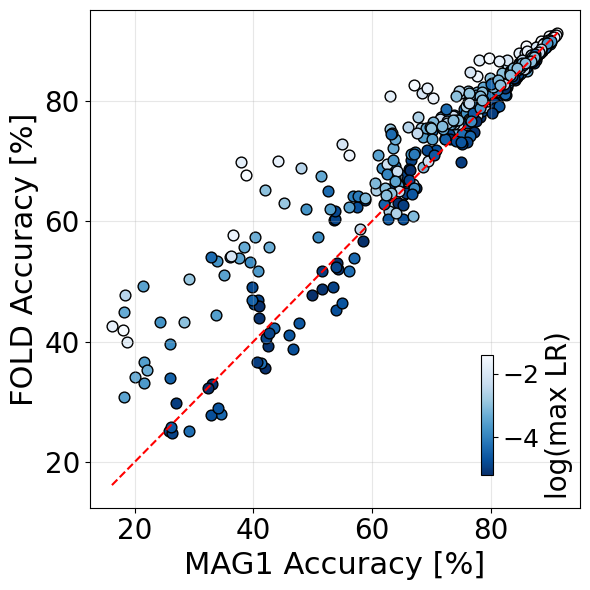

/tmp/ipython-input-3287580876.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


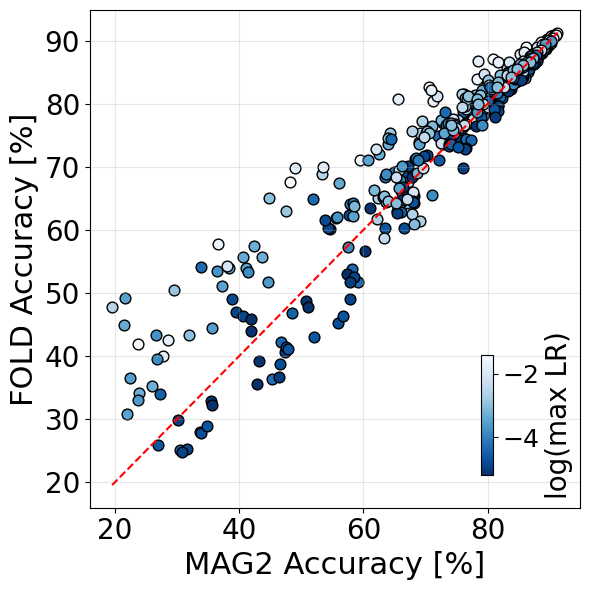

In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# --- Extract hyperparameters from filename ---
def extract_l1_lr_wd_sched(name):
    l1_match = re.search(r"l1=([0-9.eE+-]+)", name)
    lr_match = re.search(r"lr(?:_max)?=([0-9.eE+-]+)", name)  # Match lr or lr_max
    wd_match = re.search(r"wd=([0-9.eE+-]+)", name)
    sched_match = re.search(r"lr_schedule=(True|False|cyclic|none)", name)

    l1 = float(l1_match.group(1)) if l1_match else None
    lr = round(float(lr_match.group(1)), 8) if lr_match else None
    wd = round(float(wd_match.group(1)), 8) if wd_match else 0.0
    lr_schedule = sched_match.group(1).lower() in ["true", "cyclic"] if sched_match else False

    return l1, lr, wd, lr_schedule

def extract_data(text):
    pat = re.compile(r"\[MODEL\]\s+(\d+)/\d+\s+(.*?epoch=\d+\.pth)(.*?)(?=\[MODEL\]|\Z)", re.DOTALL)
    rows = []
    for m in pat.finditer(text):
        model_id, name, block = int(m[1]), m[2].strip(), m[3]
        l1, lr, wd, sched = extract_l1_lr_wd_sched(name)
        base = re.search(r"RATIO=0\.0\s+EVENT=BASE params=(\d+)\s+acc=([0-9.]+)", block)
        if not base: continue
        base_params, base_acc = int(base[1]), float(base[2])
        prunes = re.findall(r"RATIO=([0-9.]+)\s+EVENT=PRUNE params=(\d+)\s+acc=([0-9.]+)", block)
        repairs = re.findall(r"RATIO=([0-9.]+)\s+EVENT=REPAIR acc=([0-9.]+)", block)
        for (rp, pp, acc_r), (rr, _) in zip(prunes, repairs):
            if abs(float(rp)-float(rr))<1e-4 and base_acc>=FILTER_THRESHOLD:
                sparsity = round(1 - int(pp)/base_params, 3)
                rows.append((model_id, name, sparsity, float(rr), base_acc, float(acc_r), l1, lr, wd, sched))
    df = pd.DataFrame(rows, columns=["model_id","model","sparsity","ratio","acc_before","acc_after","l1","lr","wd","lr_schedule"])
    df["model"] = df["model"].str.strip()
    df[["sparsity","l1","wd"]] = df[["sparsity","l1","wd"]].round(5)
    return df


def plot_lr_scatter(x_df, y_df, x_name, y_name):
    # Rename
    x_df = x_df.rename(columns={"acc_after": "acc_x"})
    y_df = y_df.rename(columns={"acc_after": "acc_y"})

    for df in [x_df, y_df]:
        df["model"] = df["model"].str.strip()
        df["sparsity"] = df["sparsity"].round(3)

    # --- Setup legends ---
    schedule_to_marker = {True: 'o', False: 'P'}
    marker_labels = {True: "With LR Schedule", False: "No LR Schedule"}

    merged_df = pd.merge(
        y_df[["model", "ratio", "acc_y", "lr"]],
        x_df[["model", "ratio", "acc_x", "lr"]],
        on=["model", "ratio", "lr"]
    )

    # Normalize learning rate for color
    lr_vals = np.log(merged_df["lr"].values)
    norm = mcolors.Normalize(vmin=lr_vals.min(), vmax=lr_vals.max())
    cmap = cm.Blues_r

    fig, ax = plt.subplots(figsize=(6, 6))

    for _, row in merged_df.iterrows():
        color = cmap(norm(np.log(row["lr"])))
        ax.scatter(row["acc_x"], row["acc_y"], c=[color], marker='o', edgecolor="black", s=60)

    # Diagonal reference line
    min_val = min(merged_df["acc_x"].min(), merged_df["acc_y"].min())
    max_val = max(merged_df["acc_x"].max(), merged_df["acc_y"].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--')

    ax.set_xlabel(f"{x_name} Accuracy [%]", fontsize=22)
    ax.set_ylabel(f"{y_name} Accuracy [%]", fontsize=22)
    ax.tick_params(axis='both', labelsize=20)

    # --- Colorbar for learning rate ---
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar_ax = fig.add_axes([0.81, 0.20, 0.02, 0.2])
    smap = cm.ScalarMappable(norm=norm, cmap=cmap)
    cbar = fig.colorbar(smap, cax=cbar_ax, ax=ax, fraction=0.035, pad=0.02)
    cbar.set_label("log(max LR)", fontsize=20)
    cbar.ax.tick_params(labelsize=18)

    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    fig.savefig(f"{opt_name}__lr_scatter__{x_name}_vs_{y_name}.png", dpi=100)


# Extract
fold_df = extract_data(fold_text)
mag1_df = extract_data(mag1_text)
mag2_df = extract_data(mag2_text)

print(len(fold_df), len(mag1_df), len(mag2_df))

plot_lr_scatter(mag1_df, fold_df, "MAG1", "FOLD")
plot_lr_scatter(mag2_df, fold_df, "MAG2", "FOLD")


594 594 594


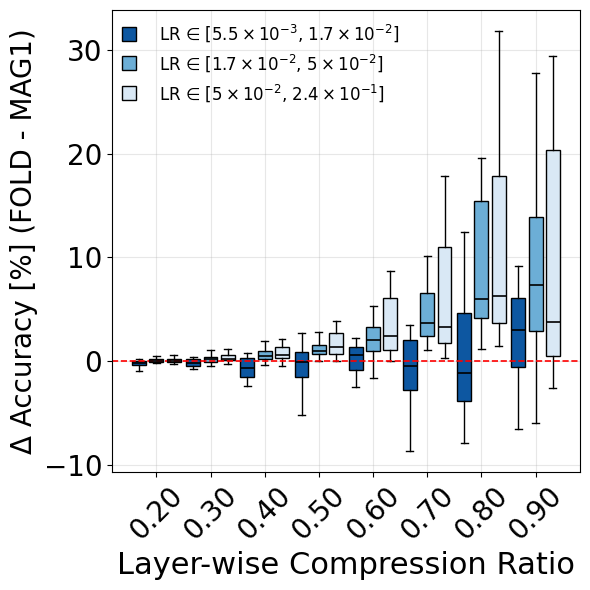

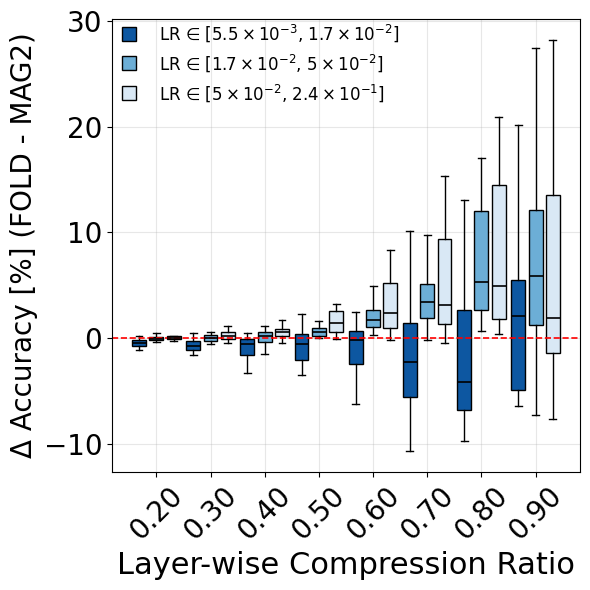

In [ ]:
def plot_fold_vs_method_box_by_ratio_lr(x_df, y_df, x_name, y_name):
    # ---- helpers ----
    def grouped_positions(x_vals, n_groups, width=0.18):
        offsets = np.linspace(-((n_groups-1)/2)*width, ((n_groups-1)/2)*width, n_groups)
        return {gi: (np.asarray(x_vals) + offsets[gi]) for gi in range(n_groups)}, width

    def _fmt_10pow(x, tol=1e-12):
        """Format scalar x > 0 as 10^n or m×10^n (LaTeX)."""
        if x is None or np.isnan(x) or x <= 0:
            return r"? "
        n = int(np.floor(np.log10(x)))
        m = x / (10**n)
        if np.isclose(m, 1.0, atol=tol):
            return rf"$10^{{{n}}}$"
        mant = f"{m:.0f}" if np.isclose(m, round(m), atol=tol) else f"{m:.2g}"
        return rf"${mant}\times 10^{{{n}}}$"

    # Rename
    x_df = x_df.rename(columns={"acc_after": "acc_x"})
    y_df = y_df.rename(columns={"acc_after": "acc_y"})

    # --- plotting (with LR binning) ---
    merged = pd.merge(
            y_df[["model","ratio","acc_y"]],
            x_df[["model","ratio","acc_x"]],
            on=["model","ratio"], how="inner"
    )

    to_num = lambda s: pd.to_numeric(s, errors="coerce")
    # parse learning rate (named 'lr_max' in your filenames)
    merged["lr"] = to_num(merged["model"].str.extract(r"lr_max=([0-9.eE+-]+)", expand=False))

    # filter + compute delta
    subset = merged.dropna(subset=["lr"]).copy()
    subset["diff"] = subset["acc_y"] - subset["acc_x"]

    # --- bin LR into 3 subranges on log-scale ---
    loglr = np.log10(subset["lr"])
    try:
        subset["lr_bin"] = pd.qcut(loglr, q=3, duplicates="drop")
    except ValueError:
        lo, hi = loglr.min(), loglr.max()
        edges = np.linspace(lo, hi, 4)
        subset["lr_bin"] = pd.cut(loglr, bins=edges, include_lowest=True)

    # ordered categories & colors
    bin_cats = subset["lr_bin"].cat.categories
    n_bins = len(bin_cats)
    bin_colors = cm.Blues_r(np.linspace(0.15, 0.85, n_bins))
    bin_to_color = {b: c for b, c in zip(bin_cats, bin_colors)}

    # figure (single panel)
    fig, ax = plt.subplots(figsize=(6, 6))

    all_ratios = sorted(subset["ratio"].unique())
    # optional: drop the first ratio like in your earlier code
    if len(all_ratios) > 1:
        all_ratios = all_ratios[1:]

    x = np.arange(len(all_ratios), dtype=float)
    pos_map, box_w = grouped_positions(x, n_groups=n_bins, width=0.32)

    # boxplots per (ratio, LR-bin) -- USE 'subset' consistently
    for gi, bin_cat in enumerate(bin_cats):
        pos = pos_map[gi]
        data_for_boxes, valid_pos = [], []
        for r_i, r in enumerate(all_ratios):
            vals = subset[(subset["ratio"] == r) & (subset["lr_bin"] == bin_cat)]["diff"].tolist()
            if vals:
                data_for_boxes.append(vals)
                valid_pos.append(pos[r_i])
        if data_for_boxes:
            bp = ax.boxplot(
                data_for_boxes,
                positions=valid_pos,
                widths=box_w*0.8,
                patch_artist=True,
                showfliers=False
            )
            for patch in bp["boxes"]:
                patch.set(facecolor=bin_to_color[bin_cat], alpha=1.0, edgecolor="black")
            for whisk in bp["whiskers"]:
                whisk.set(color="black", linewidth=1)
            for cap in bp["caps"]:
                cap.set(color="black", linewidth=1)
            for median in bp["medians"]:
                median.set(color="black", linewidth=1.2)

    # aesthetics
    ax.set_xlabel("Layer-wise Compression Ratio", fontsize=22)
    ax.set_xticks(x)
    ax.set_xticklabels([f"{r:.2f}" if isinstance(r, float) else str(r) for r in all_ratios], rotation=45, fontsize=20)
    ax.axhline(0.0, color="red", linestyle="--", linewidth=1.2)  # accuracy gain = 0
    ax.tick_params(axis="y", labelsize=20)
    ax.grid(True, alpha=0.3)
    # ax.set_ylim(-25, 32)
    ax.set_ylabel(f"Δ Accuracy [%] ({y_name} - {x_name})", fontsize=20)

    # Legend with LR bin ranges (formatted as 10^n)
    handles = []
    for gi, bin_cat in enumerate(bin_cats):
        left_log, right_log = float(bin_cat.left), float(bin_cat.right)
        left_lr, right_lr = 10**left_log, 10**right_log
        lbl = rf"LR ∈ [{_fmt_10pow(left_lr)}, {_fmt_10pow(right_lr)}]"
        h = plt.Line2D([0],[0], marker='s', color='w',
                       markerfacecolor=bin_colors[gi], markeredgecolor='black',
                        markersize=10, linestyle='None', label=lbl)
        handles.append(h)

    fig.legend(handles=handles, loc="upper left",
                   bbox_to_anchor=(0.17, 0.98), fontsize=12, frameon=False)

    fig.tight_layout()
    plt.show()
    fig.savefig(f"{opt_name}__lr_hist__{x_name}_vs_{y_name}.png", dpi=100)


# Extract
fold_df = extract_data(fold_text)
mag1_df = extract_data(mag1_text)
mag2_df = extract_data(mag2_text)

print(len(fold_df), len(mag1_df), len(mag2_df))

plot_fold_vs_method_box_by_ratio_lr(mag1_df, fold_df, "MAG1", "FOLD")
plot_fold_vs_method_box_by_ratio_lr(mag2_df, fold_df, "MAG2", "FOLD")


594 594 594


/tmp/ipython-input-1914804249.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


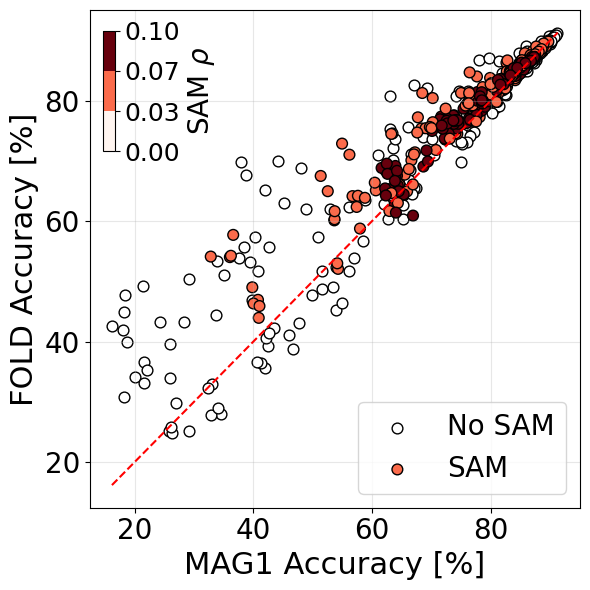

/tmp/ipython-input-1914804249.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


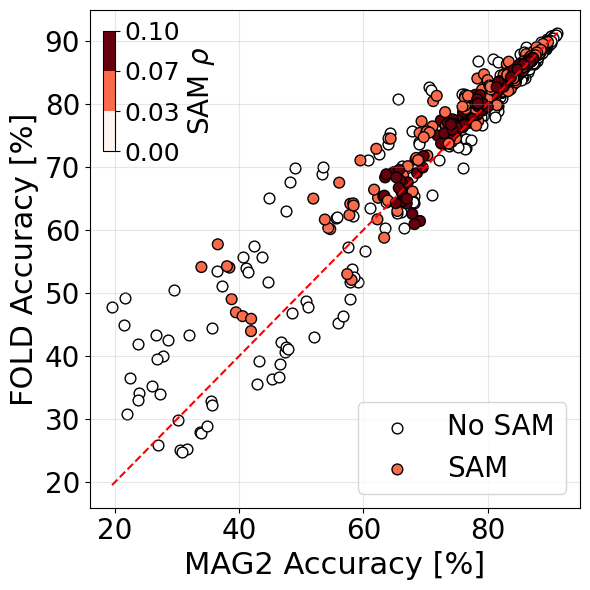

In [ ]:
# --- Extraction Helpers ---
def extract_from_name(name):
    lr = float(re.search(r"lr=([0-9.eE+-]+)", name).group(1)) if "lr=" in name else None
    wd = float(re.search(r"wd=([0-9.eE+-]+)", name).group(1)) if "wd=" in name else 0.0

    sam_rho_match = re.search(r"sam_rho=([0-9.eE+-]+)", name)
    raug_match = re.search(r"rand_aug=(True|False)", name, re.IGNORECASE)

    sam_rho = float(sam_rho_match.group(1))
    raug = raug_match.group(1) == "True" if raug_match else False

    return lr, wd, sam_rho, raug

def extract_data(text):
    pat = re.compile(r"\[MODEL\]\s+(\d+)/\d+\s+(.*?epoch=\d+\.pth)(.*?)(?=\[MODEL\]|\Z)", re.DOTALL)
    rows = []
    for m in pat.finditer(text):
        model_id, name, block = int(m[1]), m[2].strip(), m[3]
        lr, wd, sam_rho, raug = extract_from_name(name)
        base = re.search(r"RATIO=0\.0\s+EVENT=BASE params=(\d+)\s+acc=([0-9.]+)", block)
        if not base: continue
        base_params, base_acc = int(base[1]), float(base[2])
        prunes = re.findall(r"RATIO=([0-9.]+)\s+EVENT=PRUNE params=(\d+)\s+acc=([0-9.]+)", block)
        repairs = re.findall(r"RATIO=([0-9.]+)\s+EVENT=REPAIR acc=([0-9.]+)", block)
        for (rp, pp, acc_r), (rr, _) in zip(prunes, repairs):
            if abs(float(rp)-float(rr))<1e-4 and base_acc>=FILTER_THRESHOLD:
                sparsity = round(1 - int(pp)/base_params, 3)
                rows.append((model_id, name, sparsity, float(rr), base_acc, float(acc_r), lr, wd, sam_rho, raug))
    df = pd.DataFrame(rows, columns=["model_id","model","sparsity","ratio","acc_before","acc_after","lr","wd", "sam_rho", "raug"])
    df["model"] = df["model"].str.strip()
    return df


def plot_sam_scatter(x_df, y_df, x_name, y_name):
    # Rename
    x_df = x_df.rename(columns={"acc_after": "acc_x"})
    y_df = y_df.rename(columns={"acc_after": "acc_y"})

    merged_df = pd.merge(
        y_df[["model_id", "model", "ratio", "acc_y", "lr", "wd", "sam_rho", "raug"]],
        x_df[["model", "ratio", "acc_x", "lr", "wd", "sam_rho", "raug"]],
        on=["model", "ratio", "lr", "wd", "sam_rho", "raug"]
    )

    # --- Plotting ---
    rho_bins = np.array([0.0, 0.025, 0.075, 0.1])
    norm = mcolors.BoundaryNorm(boundaries=rho_bins, ncolors=256)

    fig, ax = plt.subplots(figsize=(6, 6))

    df = merged_df
    sam_mask = df["sam_rho"] > 0
    no_sam_df = df[~sam_mask]
    sam_df = df[sam_mask]

    # No SAM = white
    ax.scatter(no_sam_df["acc_x"], no_sam_df["acc_y"],
            c="white", edgecolor="black", marker='o', s=60,
            label="No SAM")

    # SAM = color by rho
    if not sam_df.empty:
        colors = cm.Reds(norm(sam_df["sam_rho"]))
        ax.scatter(sam_df["acc_x"], sam_df["acc_y"],
                c=colors, edgecolor="black", marker='o', s=60, label="SAM")

    # y = x line
    if not df.empty:
        min_acc = df[["acc_x", "acc_y"]].min().min()
        max_acc = df[["acc_x", "acc_y"]].max().max()
        ax.plot([min_acc, max_acc], [min_acc, max_acc], 'r--', label=None)

    ax.set_xlabel(f"{x_name} Accuracy [%]", fontsize=22)
    ax.set_ylabel(f"{y_name} Accuracy [%]", fontsize=22)
    ax.legend(fontsize=20, loc="lower right")

    ax.tick_params(axis='both', labelsize=20)
    ax.grid(True, alpha=0.3)

    # --- Shared Colorbar ---
    cbar_ax = fig.add_axes([0.18, 0.74, 0.02, 0.2])
    sm = cm.ScalarMappable(norm=norm, cmap=cm.Reds)
    cb = fig.colorbar(sm, cax=cbar_ax)
    cb.set_label(r"SAM $\rho$", fontsize=20)       # Label font size
    cb.ax.tick_params(labelsize=18)                     # Tick label font size
    cb.set_ticks(rho_bins)
    cb.set_ticklabels([f"{b:.2f}" for b in rho_bins])

    plt.tight_layout()
    plt.show()
    fig.savefig(f"{opt_name}__sam_scatter__{x_name}_vs_{y_name}.png", dpi=100)

# Extract
fold_df = extract_data(fold_text)
mag1_df = extract_data(mag1_text)
mag2_df = extract_data(mag2_text)

print(len(fold_df), len(mag1_df), len(mag2_df))

plot_sam_scatter(mag1_df, fold_df, "MAG1", "FOLD")
plot_sam_scatter(mag2_df, fold_df, "MAG2", "FOLD")


594 594 594


/tmp/ipython-input-1196285900.py:52: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged["raug"] = merged["model"].str.extract(r"(?i)rand_aug=(True|False)", expand=False).map({"True": True, "False": False}).fillna(False)
/tmp/ipython-input-1196285900.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


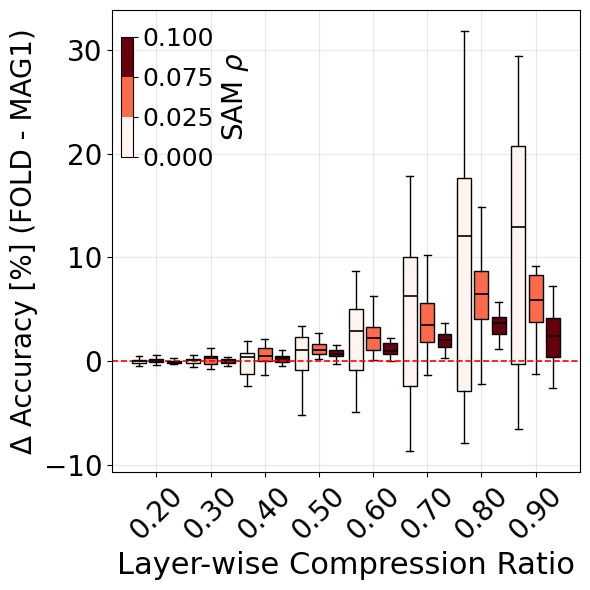

/tmp/ipython-input-1196285900.py:52: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged["raug"] = merged["model"].str.extract(r"(?i)rand_aug=(True|False)", expand=False).map({"True": True, "False": False}).fillna(False)
/tmp/ipython-input-1196285900.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


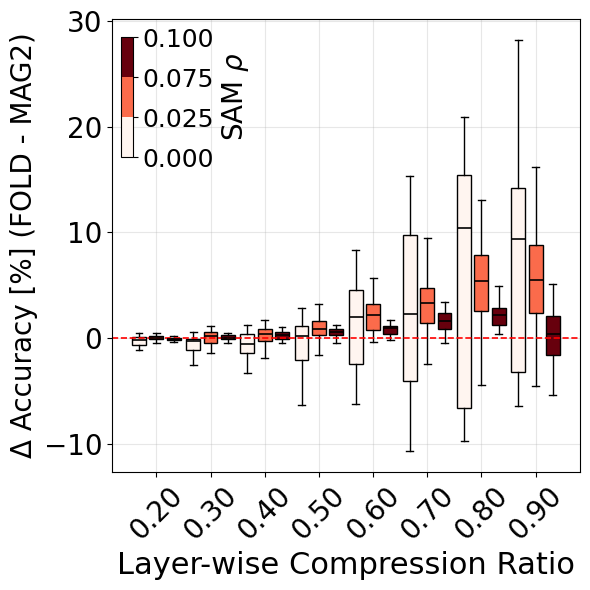

In [ ]:
def plot_fold_vs_method_box_by_ratio_sam(x_df, y_df, x_name, y_name, l1_target=0.0):
    # --- config for SAM ρ binning & colors ---
    rho_bins = np.array([0.0, 0.025, 0.075, 0.10])  # [0, 0.025), [0.025, 0.075), [0.075, 0.10]
    norm = mcolors.BoundaryNorm(boundaries=rho_bins, ncolors=256)
    cmap = cm.Reds

    def rho_bin_label(low, high):
        # closed on left, open on right except final bin which is closed-closed for labeling clarity
        if high == rho_bins[-1]:
            return f"[{low:.3f}, {high:.3f}]"
        return f"[{low:.3f}, {high:.3f})"

    # helper for grouped positions (group = rho-bin within each ratio)
    def grouped_positions(x_vals, n_groups, width=0.20):
        offsets = np.linspace(-((n_groups-1)/2)*width, ((n_groups-1)/2)*width, n_groups)
        return {gi: (np.asarray(x_vals) + offsets[gi]) for gi in range(n_groups)}, width

    # Precompute discrete bin colors and labels
    bin_edges = list(zip(rho_bins[:-1], rho_bins[1:]))
    bin_labels = [rho_bin_label(a, b) for a, b in bin_edges]
    # sample the colormap at bin midpoints for consistent box colors
    bin_mids = [(a + b) / 2.0 for a, b in bin_edges]
    bin_colors = [cmap(norm(m)) for m in bin_mids]

    # Map ρ to bin index (-1 for exactly 0 with no SAM when bins start at 0.0; we still place it in first bin)
    def rho_to_bin_idx(r):
        # Put r=0 into the first bin [0,0.025)
        if r <= rho_bins[1] and r >= rho_bins[0]:
            return 0
        for i, (a, b) in enumerate(bin_edges):
            if (r >= a) and (r < b):
                return i
        # if equals last edge, place into last bin
        if np.isclose(r, rho_bins[-1]):
            return len(bin_edges) - 1
        return None


    # Rename
    x_df = x_df.rename(columns={"acc_after": "acc_x"})
    y_df = y_df.rename(columns={"acc_after": "acc_y"})

    merged = pd.merge(
        y_df[["model","ratio","acc_y"]],
        x_df[["model","ratio","acc_x"]],
        on=["model","ratio"], how="inner"
    )

    to_num = lambda s: pd.to_numeric(s, errors="coerce")

    merged["sam_rho"] = to_num(merged["model"].str.extract(r"sam_rho=([0-9.eE+-]+)", expand=False)).fillna(0.0)
    merged["raug"] = merged["model"].str.extract(r"(?i)rand_aug=(True|False)", expand=False).map({"True": True, "False": False}).fillna(False)

    subset = merged

    # Δ accuracy
    subset["diff"] = subset["acc_y"] - subset["acc_x"]

    # Determine available ratios and valid rho-bin groups present in data
    all_ratios = sorted(subset["ratio"].unique())
    all_ratios = all_ratios[1:]

    # Figure setup: one row with 2 panels for l1 targets (if present)
    # present_l1 = [v for v in [l1_target] if v in subset["l1"].unique()]
    fig, ax = plt.subplots(figsize=(6, 6))

    df = subset

    x = np.arange(len(all_ratios), dtype=float)
    n_groups = len(bin_edges)
    pos_map, box_w = grouped_positions(x, n_groups, width=0.32)

    # Build and draw boxplots per (ratio, rho-bin)
    for gi, (a, b) in enumerate(bin_edges):
        pos = pos_map[gi]
        data_for_boxes, valid_pos = [], []
        for r_i, r in enumerate(all_ratios):
            vals = df[(df["ratio"] == r) &
                    (df["sam_rho"] >= a) &
                    (df["sam_rho"] <  b if b < rho_bins[-1] else df["sam_rho"] <= b)
            ]["diff"].tolist()
            if vals:
                data_for_boxes.append(vals)
                valid_pos.append(pos[r_i])
        if data_for_boxes:
            bp = ax.boxplot(
                    data_for_boxes,
                    positions=valid_pos,
                    widths=box_w*0.8,
                    patch_artist=True,
                    showfliers=False
            )
            # style
            for patch in bp["boxes"]:
                patch.set(facecolor=bin_colors[gi], alpha=1.0, edgecolor="black")
            for whisk in bp["whiskers"]:
                whisk.set(color="black", linewidth=1)
            for cap in bp["caps"]:
                cap.set(color="black", linewidth=1)
            for median in bp["medians"]:
                median.set(color="black", linewidth=1.2)

    # aesthetics
    ax.set_xlabel("Layer-wise Compression Ratio", fontsize=22)
    ax.set_xticks(x)
    ax.set_xticklabels([f"{r:.2f}" if isinstance(r, float) else str(r) for r in all_ratios], rotation=45, fontsize=20)
    ax.axhline(0.0, color="red", linestyle="--", linewidth=1.2)  # accuracy gain = 0
    ax.tick_params(axis="y", labelsize=20)
    ax.grid(True, alpha=0.3)

    ax.set_ylabel(f"Δ Accuracy [%] ({y_name} - {x_name})", fontsize=20)

    if (subset["sam_rho"] > 0).any():
        cbar_ax = fig.add_axes([0.21, 0.73, 0.02, 0.2])
        smap = cm.ScalarMappable(norm=norm, cmap=cmap)
        cbar = fig.colorbar(smap, cax=cbar_ax, ax=ax, fraction=0.035, pad=0.02)
        cbar.set_label(r"SAM $\rho$", fontsize=20)
        cbar.set_ticks(rho_bins)
        cbar.set_ticklabels([f"{b:.3f}" for b in rho_bins])
        cbar.ax.tick_params(labelsize=18)

    plt.tight_layout()
    fig.savefig(f"{opt_name}__sam_hist__{x_name}_vs_{y_name}.png", dpi=100)
    plt.show()


# Extract
fold_df = extract_data(fold_text)
mag1_df = extract_data(mag1_text)
mag2_df = extract_data(mag2_text)

print(len(fold_df), len(mag1_df), len(mag2_df))

plot_fold_vs_method_box_by_ratio_sam(mag1_df, fold_df, "MAG1", "FOLD")
plot_fold_vs_method_box_by_ratio_sam(mag2_df, fold_df, "MAG2", "FOLD")


#Fine-tune Only LN

594 594 594


/tmp/ipython-input-990365097.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


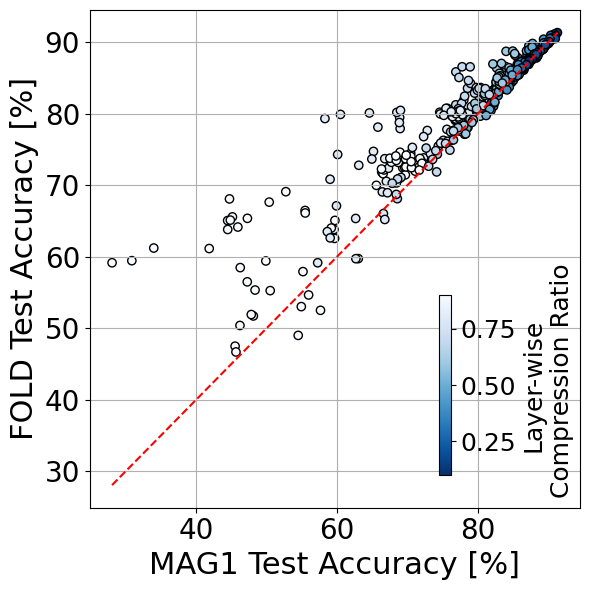

/tmp/ipython-input-990365097.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


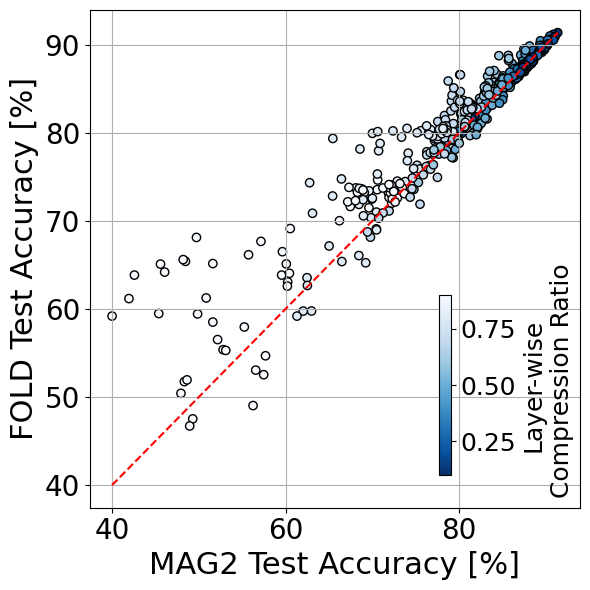

In [ ]:
import re
import pandas as pd

def extract_before_after_with_id(text):
    # Match each [MODEL] block
    pattern = re.compile(r"\[MODEL\]\s+(\d+)/\d+.*?([^\s]+\.pth)(.*?)(?=\[MODEL\]|\Z)", re.DOTALL)
    entries = []
    for match in pattern.finditer(text):
        model_id = match.group(1)
        model_name = match.group(2)
        block = match.group(3)

        # Baseline (RATIO=0.0, EVENT=BASE)
        base_match = re.search(r"RATIO=0\.0\s+EVENT=BASE[^\n]*acc=([0-9.]+)", block)
        if not base_match:
            continue
        acc_before = float(base_match.group(1))

        if acc_before < FILTER_THRESHOLD:
          continue

        # REPAIR events for other ratios
        # Match lines like "RATIO=0.1 EVENT=REPAIR acc=93.33"
        repair_pattern = r"RATIO=([0-9.]+)\s+EVENT=REPAIR[^\n]*acc=([0-9.]+)"
        for ratio_str, acc_after_str in re.findall(repair_pattern, block):
            entries.append((
                model_id,
                model_name,
                float(ratio_str),
                acc_before,
                float(acc_after_str)
            ))

    return pd.DataFrame(entries, columns=["model_id", "model", "ratio", "acc_before", "acc_after"])


def plot_compration_ratio_scatter(x_df, y_df, x_name, y_name):
    # Rename
    x_df = x_df.rename(columns={"acc_after": "acc_x"})
    y_df = y_df.rename(columns={"acc_after": "acc_y"})
    # Reduce
    y_df = y_df[["model_id", "model", "ratio", "acc_y"]]
    x_df = x_df[["model_id", "model", "ratio", "acc_x"]]
    # Merge
    merged_df = pd.merge(y_df, x_df, on=["model_id", "model", "ratio"])

    norm = plt.Normalize(merged_df["ratio"].min(), merged_df["ratio"].max())
    cmap = cm.Blues_r

    # Plot with doubled font sizes
    fig, ax = plt.subplots(figsize=(6, 6))

    scatter = ax.scatter(
        merged_df["acc_x"], merged_df["acc_y"],
        c=merged_df["ratio"], cmap=cmap, norm=norm,
        marker='o', edgecolor='black'
    )

    min_val = merged_df[["acc_x", "acc_y"]].min().min()
    max_val = merged_df[["acc_x", "acc_y"]].max().max()
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', label="y = x")

    # Axis labels
    ax.set_xlabel(f"{x_name} Test Accuracy [%]", fontsize=22)
    ax.set_ylabel(f"{y_name} Test Accuracy [%]", fontsize=22)

    # Tick labels
    ax.tick_params(axis='both', labelsize=20)

    # Colorbar
    cbar_ax = fig.add_axes([0.74, 0.20, 0.02, 0.3])
    smap = cm.ScalarMappable(norm=norm, cmap=cmap)
    cbar = fig.colorbar(smap, cax=cbar_ax, ax=ax, fraction=0.035, pad=0.02)
    cbar.set_label("Layer-wise\n Compression Ratio", fontsize=18)
    cbar.ax.tick_params(labelsize=18)

    # Grid and layout
    ax.grid(True)
    fig.tight_layout()
    plt.show()
    fig.savefig(f"{opt_name}__ftLN__compression_ratio_scatter__{x_name}_vs_{y_name}.png", dpi=100)


# Extract
fold_df = extract_before_after_with_id(fold_text)
mag1_df = extract_before_after_with_id(mag1_text)
mag2_df = extract_before_after_with_id(mag2_text)

# Print
print(len(fold_df), len(mag1_df), len(mag2_df))

plot_compration_ratio_scatter(mag1_df, fold_df, "MAG1", "FOLD")
plot_compration_ratio_scatter(mag2_df, fold_df, "MAG2", "FOLD")


594 594 594


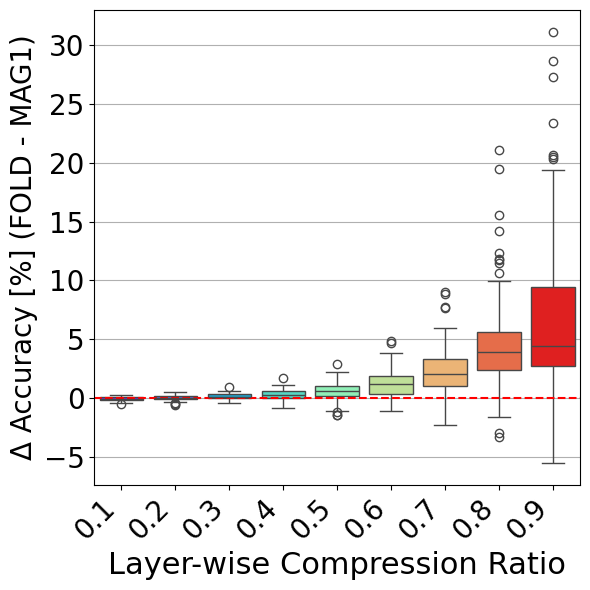

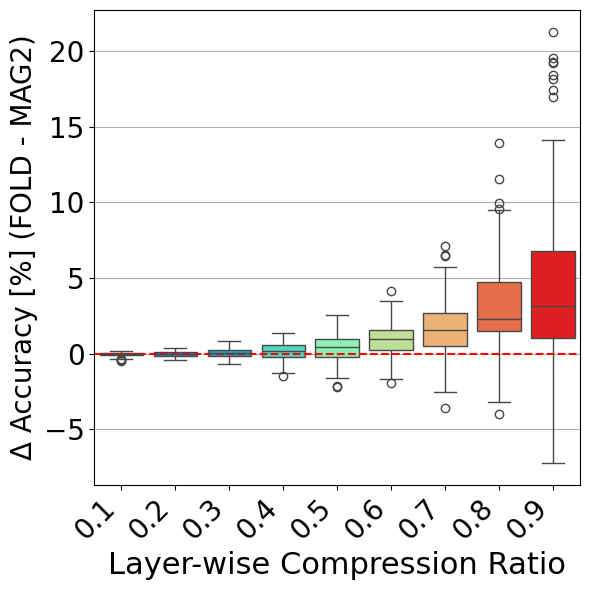

In [ ]:
def extract_with_relative_accuracy(text):
    # Match each model block
    pattern = re.compile(r"\[MODEL\] (\d+)/\d+\s+(.*?)\.pth(.*?)(?=\[MODEL\]|\Z)", re.DOTALL)
    entries = []

    for match in pattern.finditer(text):
        model_name = match.group(2).strip()
        block = match.group(3)

        # Extract BASE (before pruning) and REPAIR (after repair)
        before = re.findall(r"RATIO=([0-9.]+)\s+EVENT=BASE params=(\d+)\s+acc=([0-9.]+)", block)

        if before:
            base_ratio, base_params, base_acc = before[0]
            base_params = int(base_params)
            base_acc = float(base_acc)

            if base_acc < FILTER_THRESHOLD:
                continue

            # Match each PRUNE ratio and corresponding REPAIR accuracy
            prunes = re.findall(r"RATIO=([0-9.]+)\s+EVENT=PRUNE params=(\d+)\s+acc=([0-9.]+)", block)
            repairs = re.findall(r"RATIO=([0-9.]+)\s+EVENT=REPAIR acc=([0-9.]+)", block)

            for (r_p, p_p, _), (r_r, acc_r) in zip(prunes, repairs):
                if abs(float(r_p) - float(r_r)) < 1e-4:
                    sparsity = round(1.0 - int(p_p) / base_params, 2)
                    entries.append((model_name, sparsity, float(r_r), base_acc, float(acc_r)))

    return pd.DataFrame(entries, columns=["model", "sparsity", "ratio", "acc_before", "acc_after"])


def plot_compration_ratio_hist(x_df, y_df, x_name, y_name):
    # Rename
    x_df = x_df.rename(columns={"acc_after": "acc_x"})
    y_df = y_df.rename(columns={"acc_after": "acc_y"})
    # Merge
    merged_df = pd.merge(y_df[["model", "ratio", "acc_y"]], x_df[["model", "ratio", "acc_x"]], on=["model", "ratio"])

    # Compute relative difference
    merged_df["diff"] = merged_df["acc_y"] - merged_df["acc_x"]
    boxplot_df = merged_df[["ratio", "diff"]].copy()

    # Get sorted unique sparsities
    unique_sparsities = sorted(boxplot_df["ratio"].unique())
    cmap = colormaps["Blues_r"]
    palette = [cmap(0.3 + 0.6 * i / max(len(unique_sparsities) - 1, 1)) for i in range(len(unique_sparsities))]
    palette_dict = dict(zip(unique_sparsities, palette))

    # Plotting with increased font sizes
    fig = plt.figure(figsize=(6, 6))
    sns.boxplot(
        data=boxplot_df,
        x="ratio",
        y="diff",
        hue="ratio",
        palette="rainbow",
        dodge=False,
        legend=False
    )

    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Layer-wise Compression Ratio", fontsize=22)
    plt.ylabel(f"Δ Accuracy [%] ({y_name} - {x_name})", fontsize=20)

    plt.xticks(rotation=45, ha="right", fontsize=20)
    plt.yticks(fontsize=20)

    plt.grid(True, axis='y')
    # plt.ylim(-30, 40)
    plt.tight_layout()
    plt.show()
    fig.savefig(f"{opt_name}__ftLN__compression_ratio_hist__{x_name}_vs_{y_name}.png", dpi=100)


# Extract
fold_df = extract_with_relative_accuracy(fold_text)
mag1_df = extract_with_relative_accuracy(mag1_text)
mag2_df = extract_with_relative_accuracy(mag2_text)

# Print
print(len(fold_df), len(mag1_df), len(mag2_df))

plot_compration_ratio_hist(mag1_df.copy(), fold_df.copy(), "MAG1", "FOLD")
plot_compration_ratio_hist(mag2_df, fold_df, "MAG2", "FOLD")


#Full Fine-tuning

In [ ]:
# Load text content
with open(f"fold", "r") as f:
    fold_text = f.read()
with open(f"mag-l1", "r") as f:
    mag1_text = f.read()
with open(f"mag-l2", "r") as f:
    mag2_text = f.read()

2970 2970 2970


/tmp/ipython-input-450054136.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


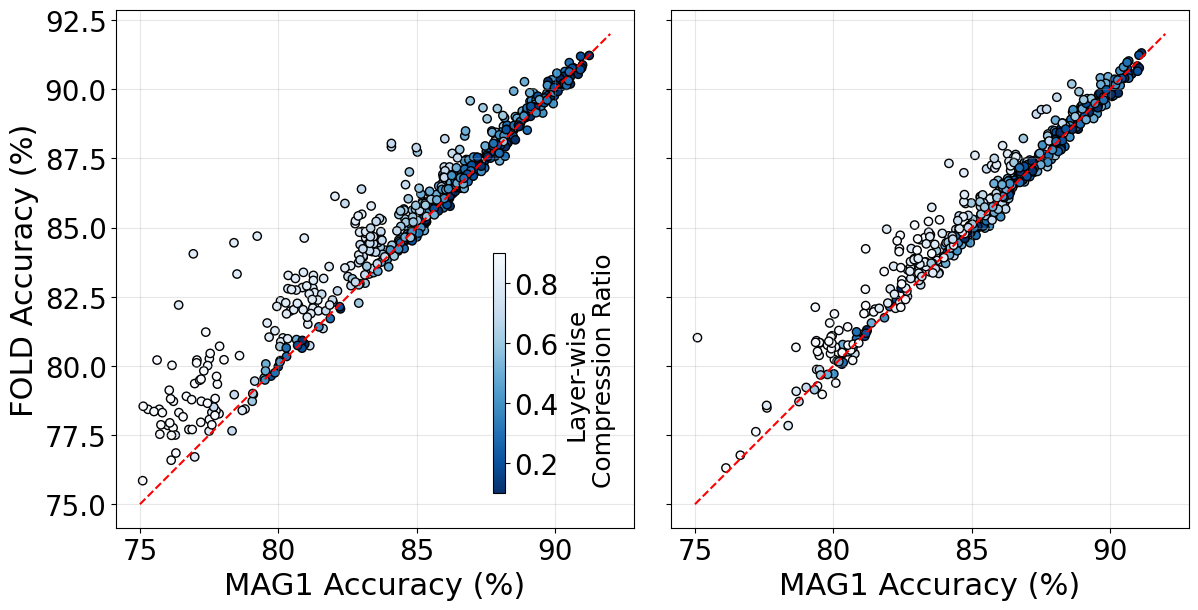

/tmp/ipython-input-450054136.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


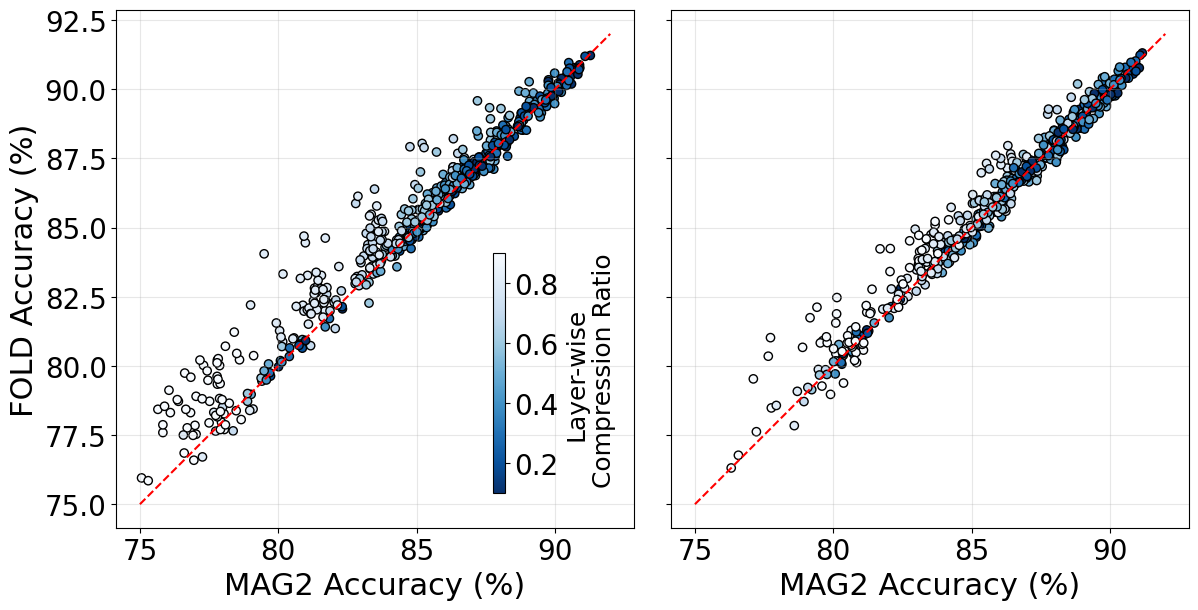

In [ ]:
import re, pandas as pd

def parse_epoch_acc(text):
    """
    Extracts: model_id, ratio, epoch, acc (from FINETUNE_EPOCH events)
    """
    parts = re.split(r"\[MODEL\] (\d+)/\d+ .*?\.pth", text)[1:]
    records = []
    for i in range(0, len(parts), 2):
        model_id = int(parts[i])
        block = parts[i + 1]

        # Baseline (RATIO=0.0, EVENT=BASE)
        base_match = re.search(r"RATIO=0\.0\s+EVENT=BASE[^\n]*acc=([0-9.]+)", block)
        if not base_match:
            continue
        acc_before = float(base_match.group(1))

        if acc_before < FILTER_THRESHOLD:
          continue

        for m in re.finditer(r"RATIO=([\d.]+)\s+EVENT=FINETUNE_EPOCH(\d+)\s+acc=([\d.]+)", block):
            records.append({
                "model_id": model_id,
                "ratio": float(m.group(1)),
                "epoch": int(m.group(2)),
                "acc": float(m.group(3))
            })
    return pd.DataFrame(records)


# -------- Extract data for both methods --------
fold_df = parse_epoch_acc(fold_text)
mag1_df = parse_epoch_acc(mag1_text)
mag2_df = parse_epoch_acc(mag2_text)

print(len(fold_df), len(mag1_df), len(mag2_df))

for method_name, method_df in zip(["MAG1","MAG2"], [mag1_df, mag2_df]):
    # Merge by model_id, ratio, epoch
    merged = pd.merge(
        fold_df, method_df,
        on=["model_id", "ratio", "epoch"],
        suffixes=("_fold", "")
    )

    # ---- Plot ----
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    cmap = cm.Blues_r
    norm = mcolors.Normalize(vmin=merged["ratio"].min(), vmax=merged["ratio"].max())

    for i, epoch in enumerate([1, 5]):
        ax = axes[i]
        data = merged[merged["epoch"] == epoch]
        lomin = 75
        himax = 92
        data = data[data["acc"]>lomin]
        data = data[data["acc_fold"]>lomin]
        data = data[data["acc"]<himax]
        data = data[data["acc_fold"]<himax]

        sc = ax.scatter(data["acc"], data["acc_fold"],
                        c=cmap(norm(data["ratio"].values)), edgecolors="black")

        # Diagonal y=x
        lo = min(data["acc"].min(), data["acc_fold"].min())
        hi = max(data["acc"].max(), data["acc_fold"].max())
        lo = min(lo, lomin)
        hi = max(hi, himax)
        ax.plot([lo, hi], [lo, hi], 'r--', alpha=1.0)

        ax.set_xlabel(f"{method_name} Accuracy (%)", fontsize=22)
        if i == 0:
            ax.set_ylabel("FOLD Accuracy (%)", fontsize=22)

        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.set_aspect('equal', adjustable='box')
        ax.grid(True, alpha=0.3)

    # Colorbar
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cax = fig.add_axes([0.40, 0.17, 0.01, 0.4])
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
    cbar.set_label("Layer-wise\n Compression Ratio", fontsize=18)
    cbar.ax.tick_params(labelsize=20)

    fig.tight_layout()
    fig.savefig(f"{opt_name}__fold_vs_{method_name}_after_ft.png", dpi=100)
    plt.show()

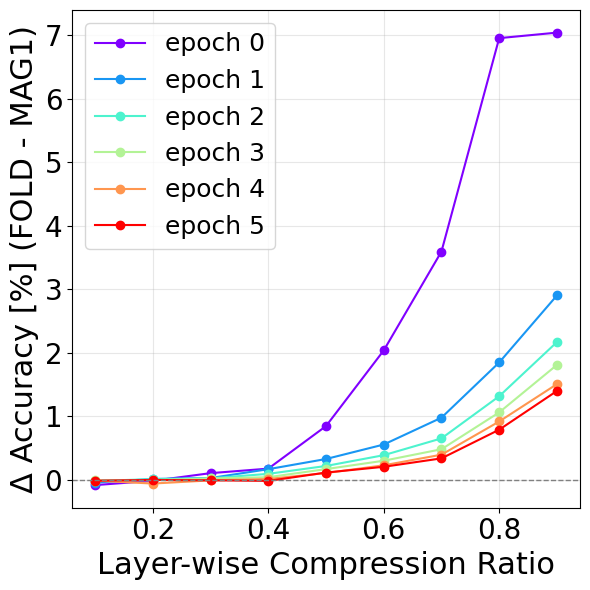

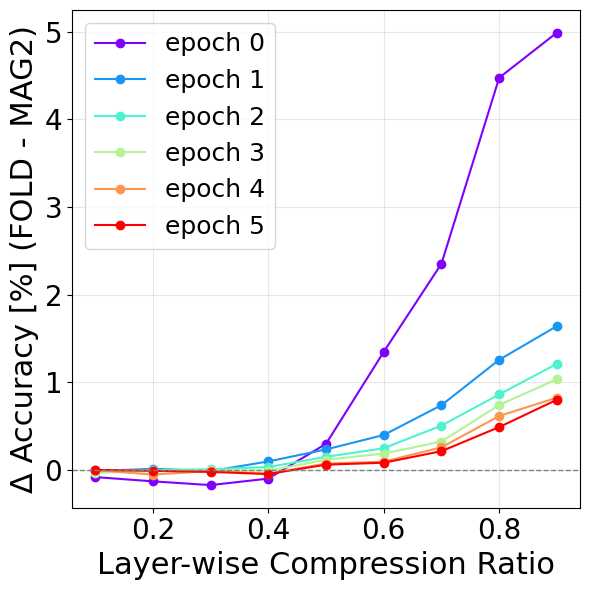

In [ ]:
def parse_epoch_acc(text):
    """Extract test accuracy for REPAIR (epoch 0) and FINETUNE_EPOCHx (epochs 1-5)."""
    records = []
    blocks = re.split(r"\[MODEL\]\s+(\d+)/\d+\s+.*?\.pth", text)[1:]

    for i in range(0, len(blocks), 2):
        model_id = int(blocks[i])
        ratio = None
        for line in blocks[i + 1].splitlines():
            m_ratio = re.search(r"RATIO=([\d.]+)", line)
            if m_ratio: ratio = float(m_ratio.group(1))

            # Baseline (RATIO=0.0, EVENT=BASE)
            base_match = re.search(r"RATIO=0\.0\s+EVENT=BASE[^\n]*acc=([0-9.]+)", blocks[i + 1])
            if not base_match:
                continue
            acc_before = float(base_match.group(1))

            if acc_before < FILTER_THRESHOLD:
              continue

            if "EVENT=PRUNE" in line:
                acc = re.search(r"acc=([\d.]+)", line)
                if acc: records.append((model_id, ratio, 0, float(acc.group(1))))

            m_ft = re.search(r"EVENT=FINETUNE_EPOCH(\d+)\s+acc=([\d.]+)", line)
            if m_ft:
                records.append((model_id, ratio, int(m_ft.group(1)), float(m_ft.group(2))))

    return pd.DataFrame(records, columns=["model_id", "ratio", "epoch", "test_acc"])


# -------- Extract for both methods (add include/exclude filters if you want) --------
fold_df = parse_epoch_acc(fold_text).rename(columns={"test_acc": "acc_fold"})
mag1_df = parse_epoch_acc(mag1_text).rename(columns={"test_acc": "acc"})
mag2_df = parse_epoch_acc(mag2_text).rename(columns={"test_acc": "acc"})

for method_name, method_df in zip(["MAG1","MAG2"], [mag1_df, mag2_df]):
    # Merge on model identity + ratio + epoch (model_id alone can collide across logs)
    merged = pd.merge(
        fold_df, method_df,
        on=["model_id", "ratio", "epoch"],
        how="inner"
    )

    if merged.empty:
        print("No overlapping REPAIR/FINETUNE entries between FOLD and MAG-L1.")
    else:
        # Relative gain: FOLD - MAG-L1 (same style as your original)
        merged["rel_gain"] = merged["acc_fold"] - merged["acc"]

        # Mean gain per pruning ratio and epoch
        mean_gain = (merged.groupby(["ratio", "epoch"])["rel_gain"]
                            .mean()
                            .reset_index()
                            .sort_values(["epoch", "ratio"]))

        # ---- Plot (keep your style & font sizes) ----
        fig, ax = plt.subplots(figsize=(6, 6))
        epochs = sorted(mean_gain["epoch"].unique())
        colors = cm.rainbow(np.linspace(0, 1, len(epochs)))

        for ep, c in zip(epochs, colors):
            d = mean_gain[mean_gain["epoch"] == ep]
            ax.plot(d["ratio"], d["rel_gain"], "o-", color=c, label=f"epoch {ep}")

        ax.axhline(0, color="gray", ls="--", lw=1)
        ax.set_xlabel("Layer-wise Compression Ratio", fontsize=22)
        ax.set_ylabel(f"Δ Accuracy [%] (FOLD - {method_name})", fontsize=22)
        ax.tick_params(labelsize=20)
        ax.legend(fontsize=18)
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        fig.savefig(f"{opt_name}__fold_vs_{method_name}_after_ft_gain.png", dpi=100)
        plt.show()

/tmp/ipython-input-3287962212.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


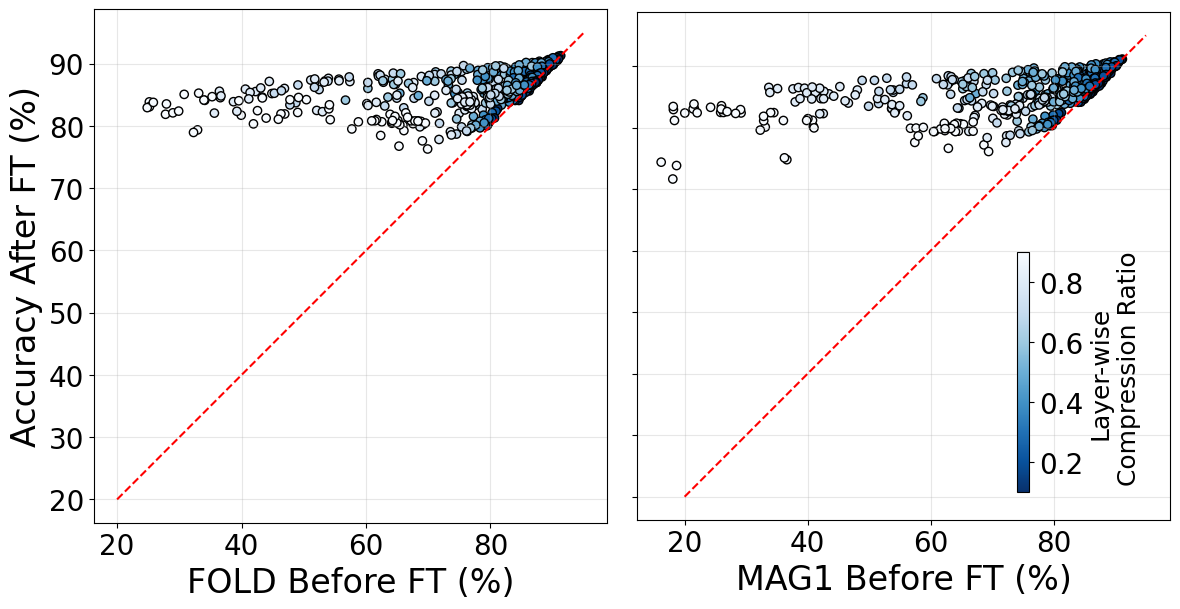

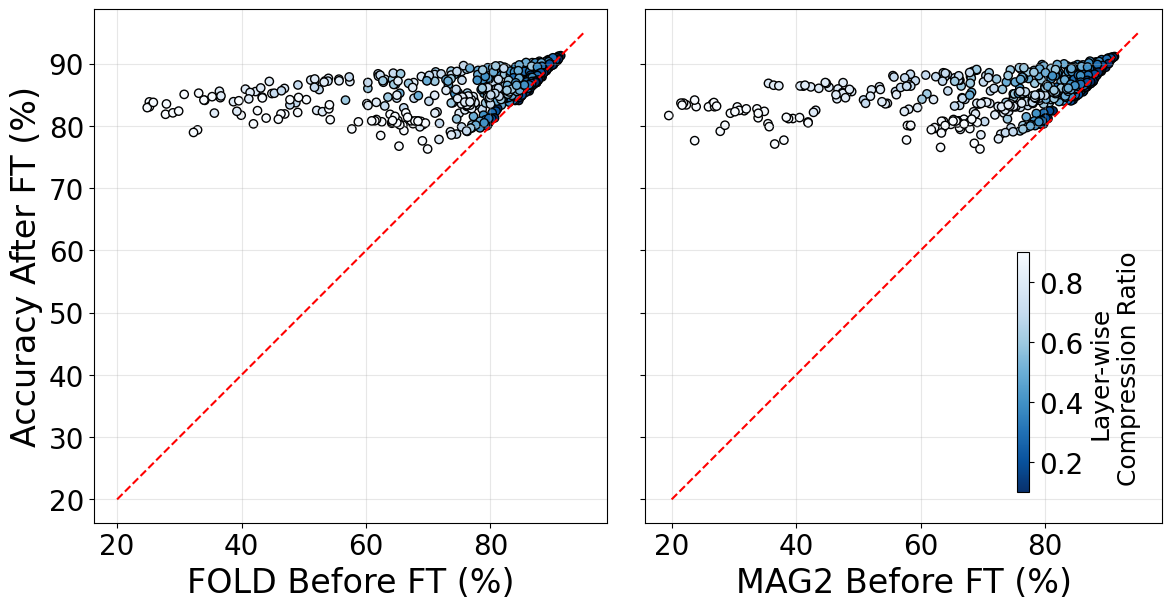

In [ ]:
def extract_before_after_ft(text):
    """Return DataFrame: model_id, ratio, before_acc (PRUNE), after_acc (FINETUNE_EPOCH5)."""
    records = []
    blocks = re.split(r"\[MODEL\]\s+(\d+)/\d+\s+.*?\.pth", text)[1:]

    for i in range(0, len(blocks), 2):
        model_id = int(blocks[i])
        ratio = before = after = None

        for line in blocks[i+1].splitlines():
            if "EVENT=BASE" in line:
                acc_before = float(re.search(r"RATIO=0\.0\s+EVENT=BASE[^\n]*acc=([0-9.]+)", line).group(1))
                if acc_before < FILTER_THRESHOLD:
                  break
            if "RATIO=" in line:
                ratio = float(re.search(r"RATIO=([\d.]+)", line).group(1))
            if "EVENT=PRUNE" in line:
                before = float(re.search(r"acc=([\d.]+)", line).group(1))
            if "EVENT=FINETUNE_EPOCH5" in line and before is not None:
                after = float(re.search(r"acc=([\d.]+)", line).group(1))
                records.append((model_id, ratio, before, after))
    return pd.DataFrame(records, columns=["model_id", "ratio", "before_acc", "after_acc"])


# --- Load logs (filter via include/exclude if desired) ---
fold_df = extract_before_after_ft(fold_text)
mag1_df = extract_before_after_ft(mag1_text)
mag2_df = extract_before_after_ft(mag2_text)

for method_name, method_df in zip(["MAG1","MAG2"], [mag1_df, mag2_df]):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

    combined_ratios = pd.concat([d["ratio"] for d in [fold_df, method_df] if not d.empty])
    norm = mcolors.Normalize(vmin=combined_ratios.min(), vmax=combined_ratios.max())
    cmap = cm.Blues_r

    def plot_method(ax, df, name):
        sc = ax.scatter(
            df["before_acc"], df["after_acc"],
            c=cmap(norm(df["ratio"].values)), edgecolors="black"
        )
        lo = min(df["before_acc"].min(), df["after_acc"].min())
        hi = max(df["before_acc"].max(), df["after_acc"].max())
        lo = 20
        hi = 95
        ax.plot([lo, hi], [lo, hi], 'r--', alpha=1.0)
        ax.set_xlabel(f"{name} Before FT (%)", fontsize=24)
        ax.set_aspect('equal', adjustable='box')
        ax.tick_params(axis='both', labelsize=20)
        return sc

    for ax, tdf, name in zip(axes, [fold_df, method_df], ["FOLD", method_name]):
        if tdf.empty:
            continue
        plot_method(ax, tdf, name)
        ax.grid(True, alpha=0.3)

    axes[0].set_ylabel("Accuracy After FT (%)", fontsize=24)


    # Shared colorbar (attach to axes to avoid tight_layout issues)
    cax = fig.add_axes([0.86, 0.17, 0.01, 0.4])
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
    cbar.set_label("Layer-wise\n Compression Ratio", fontsize=18)
    cbar.ax.tick_params(labelsize=20)

    fig.tight_layout()
    fig.savefig(f"{opt_name}__fold_and_{method_name}_before_and_after_ft.png", dpi=100)
    plt.show()

In [ ]:
!zip out.zip *.png

  adding: vit__compression_ratio_hist__MAG1_vs_FOLD.png (deflated 11%)
  adding: vit__compression_ratio_hist__MAG2_vs_FOLD.png (deflated 10%)
  adding: vit__compression_ratio_scatter__MAG1_vs_FOLD.png (deflated 5%)
  adding: vit__compression_ratio_scatter__MAG2_vs_FOLD.png (deflated 5%)
  adding: vit__fold_and_MAG1_before_and_after_ft.png (deflated 6%)
  adding: vit__fold_and_MAG2_before_and_after_ft.png (deflated 6%)
  adding: vit__fold_vs_MAG1_after_ft_gain.png (deflated 6%)
  adding: vit__fold_vs_MAG1_after_ft.png (deflated 4%)
  adding: vit__fold_vs_MAG2_after_ft_gain.png (deflated 7%)
  adding: vit__fold_vs_MAG2_after_ft.png (deflated 4%)
  adding: vit__ftLN__compression_ratio_hist__MAG1_vs_FOLD.png (deflated 11%)
  adding: vit__ftLN__compression_ratio_hist__MAG2_vs_FOLD.png (deflated 11%)
  adding: vit__ftLN__compression_ratio_scatter__MAG1_vs_FOLD.png (deflated 5%)
  adding: vit__ftLN__compression_ratio_scatter__MAG2_vs_FOLD.png (deflated 5%)
  adding: vit__lr_hist__MAG1_vs_FOLD